# Import

In [1]:
## Misc
import time
import warnings
import numpy as np
import pandas as pd

## Split
from sklearn.model_selection import train_test_split

## Model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

## Metrics
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, confusion_matrix

## Seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

## Tuning
import keras_tuner as kt

## Plotting tools
import matplotlib.pyplot as plt

In [2]:
# Allow to display all dataframes columns
pd.set_option("display.max_columns", None)

# Inactivate warnings
warnings.filterwarnings('ignore')

# Data load

In [3]:
data = pd.read_csv('./data/cotations_EDF.csv', sep=';', decimal='.', encoding='utf8', low_memory=False)

In [4]:
data.head()

,isin,date,ouverture,haut,bas,cloture,volume
0,FR0010242511,28/02/2022,7.84,8.146,7.810,8.130,4988984
1,FR0010242511,25/02/2022,7.55,8.044,7.482,7.932,7161356
2,FR0010242511,24/02/2022,7.59,7.590,7.200,7.500,9257738
3,FR0010242511,23/02/2022,8.04,8.080,7.808,7.832,2973088
4,FR0010242511,22/02/2022,7.87,7.996,7.760,7.960,3155739


# Preprocessing

In [5]:
def preprocess_input(df):
    # ---------------------------------------------------
    # STEP 1 - Dataframe preprocessing
    # ---------------------------------------------------

    # Format date
    df['date'] = pd.to_datetime(df['date'])

    # Sort dataset from past to present
    df.sort_index(axis=0, ascending=False, inplace=True)
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)

    # Create target
    df['target'] = (df['cloture'].pct_change().shift(-1) > 0).astype(int)

    # ---------------------------------------------------
    # STEP 2 - Feature engineering
    # ---------------------------------------------------

    # Variations
    df['v_ouverture'] = (df['ouverture'].diff() /
                         df['ouverture'].shift(1)) * 100
    df['v_bas'] = (df['bas'].diff() / df['bas'].shift(1)) * 100
    df['v_cloture'] = (df['cloture'].diff() / df['cloture'].shift(1)) * 100
    df['v_volume'] = (df['volume'].diff() / df['volume'].shift(1)) * 100

    # Differences
    df['d_o_h'] = df['ouverture'] - df['haut']
    df['d_o_b'] = df['ouverture'] - df['bas']
    df['d_o_c'] = df['ouverture'] - df['cloture']
    df['d_h_b'] = df['haut'] - df['bas']

    # Number of consecutive increases
    df['cons_increase'] = 0
    iteration = 0
    count = 0

    for index, row in df.iterrows():
        iteration += 1

        if iteration == 1:
            df['cons_increase'][index] = np.nan
        elif iteration > 1 and iteration < len(df):
            if df['cloture'][index] > df['cloture'][index - 1]:
                count += 1
            else:
                count = 0

            df['cons_increase'][index] = count

    # Number of consecutive decreases
    df['cons_decrease'] = 0
    iteration = 0
    count = 0

    for index, row in df.iterrows():
        iteration += 1

        if iteration == 1:
            df['cons_decrease'][index] = np.nan
        elif iteration > 1 and iteration < len(df):
            if df['cloture'][index] < df['cloture'][index - 1]:
                count += 1
            else:
                count = 0

            df['cons_decrease'][index] = count

    # Moving averages
    nb_days = [2, 3, 5, 10, 15]

    for days in nb_days:
        df['mm' + str(days)] = 0
        iteration = 0

        for index, row in df.iterrows():
            if iteration < days-1:
                df['mm' + str(days)][index] = np.nan
            else:
                df['mm' + str(days)][index] = df['cloture'][index -
                                                            (days-1):index+1].sum() / days

            iteration += 1

    # Moving exponential averages
    for days in nb_days:
        df['mme' + str(days)] = 0
        iteration = 0

        for index, row in df.iterrows():
            if iteration < days:
                df['mme' + str(days)][index] = np.nan
            else:
                df['mme' + str(days)][index] = (
                    (df['cloture'][index] - df['mm' + str(days)][index-1]) * (2/(days + 1))) + df['mm' + str(days)][index-1]

            iteration += 1

    # MACD 2-x
    df['macd_2_5'] = df['mme2'] - df['mme5']
    df['macd_2_15'] = df['mme2'] - df['mme15']

    # MACD 3-x
    df['macd_3_5'] = df['mme3'] - df['mme5']
    df['macd_3_15'] = df['mme3'] - df['mme15']

    # MACD 5-x
    df['macd_5_15'] = df['mme5'] - df['mme15']

    # Seasonality cloture
    result = seasonal_decompose(
        df.cloture, model='multiplicative', period=90, extrapolate_trend='freq')
    df['trend'] = result.trend
    data['trend_variation1'] = data['trend'].diff()
    data['trend_variation3'] = data['trend'].diff(3)
    data['trend_variation15'] = data['trend'].diff(15)

    # Make stationary
    df['cloture_adj'] = df['cloture'].diff(60)

    # Adjusted lags
    df['lag_2_adj'] = df['cloture_adj'].shift(2)
    df['lag_4_adj'] = df['cloture_adj'].shift(4)
    df['lag_5_adj'] = df['cloture_adj'].shift(5)

    # ---------------------------------------------------
    # STEP 3 - Cleaning
    # ---------------------------------------------------

    # Useless column
    df.drop(['isin', 'date', 'ouverture', 'haut', 'bas',
             'cloture', 'volume', 'mm2', 'mm3', 'mm5',
             'mm10', 'mm15', 'mme2', 'mme3', 'mme5',
             'mme10', 'mme15', 'cloture_adj'], axis=1, inplace=True)

    # Missing values
    df = df[df['lag_5_adj'].notna()]

    # Reset index to ease further treatments
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)

    return df

In [6]:
data = preprocess_input(data)

In [7]:
data.shape

(4071, 23)

In [8]:
data.head(10)

,target,v_ouverture,v_bas,v_cloture,v_volume,d_o_h,d_o_b,d_o_c,d_h_b,cons_increase,cons_decrease,macd_2_5,macd_2_15,macd_3_5,macd_3_15,macd_5_15,trend,trend_variation1,trend_variation3,trend_variation15,lag_2_adj,lag_4_adj,lag_5_adj
0,0,0.851970,1.609442,3.952991,-19.102640,-1.45,0.00,-1.30,1.45,4.0,0.0,2.285667,4.233500,1.469000,3.416833,1.947833,43.137611,0.062000,0.193500,1.130889,13.26,9.66,9.95
1,0,2.428722,-0.295671,-1.808839,-48.998794,0.00,1.29,0.73,1.29,0.0,1.0,1.462333,3.732917,1.259000,3.529583,2.270583,43.195889,0.058278,0.184500,1.104000,13.50,10.38,9.66
2,1,-2.412371,-1.715738,-0.397739,-2.327757,-0.44,0.93,-0.25,1.37,0.0,2.0,0.794000,3.448083,0.664000,3.318083,2.654083,43.252056,0.056167,0.176444,1.080222,15.05,13.26,10.38
3,0,0.169026,1.422414,0.483396,-18.583407,-0.73,0.35,-0.40,1.08,1.0,0.0,0.181667,3.048417,0.321667,3.188417,2.866750,43.303778,0.051722,0.166167,1.054167,14.15,13.50,13.26
4,0,0.717148,-1.402465,-2.572684,-19.836082,-0.20,1.35,1.17,1.55,0.0,1.0,-0.389667,2.080833,-0.191333,2.279167,2.470500,43.344389,0.040611,0.148500,1.011278,13.63,15.05,13.50
5,0,-3.664921,-2.262931,-1.073422,27.181456,-0.26,0.65,-0.08,0.91,0.0,2.0,-0.693667,1.488167,-0.443667,1.738167,2.181833,43.380944,0.036556,0.128889,0.964056,13.94,14.15,15.05
6,1,-0.434783,-0.749724,-1.757812,8.163708,-0.18,0.79,0.53,0.97,0.0,3.0,-0.909333,0.579667,-0.486000,1.003000,1.489000,43.418500,0.037556,0.114722,0.914500,12.03,13.63,14.15
7,1,-0.655022,-1.110864,1.612547,60.957697,-0.73,0.99,-0.50,1.72,1.0,0.0,-0.551000,0.595167,-0.454333,0.691833,1.146167,43.450556,0.032056,0.106167,0.861889,10.78,13.94,13.63
8,0,1.252747,3.504830,2.760870,19.394515,-2.12,0.00,-1.20,2.12,2.0,0.0,0.069667,1.045167,-0.128667,0.846833,0.975500,43.475667,0.025111,0.094722,0.821667,10.27,12.03,13.94
9,1,1.237248,0.955068,-0.401946,-53.119332,-0.97,0.13,-0.44,1.10,0.0,1.0,0.411667,0.974583,0.110000,0.672917,0.562917,43.496000,0.020333,0.077500,0.783000,10.16,10.78,12.03


# Split

## Test dataset

In [9]:
# Collect 270 rows for the test dataset
X_test = data.loc[3801:, (data.columns != 'target')]
y_test = data.loc[3801:, (data.columns == 'target')]
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_test (270, 22)
y_test (270, 1)


In [10]:
# Remove these rows from data
data = data.loc[:3800]
data.shape

(3801, 23)

## Validation dataset

In [11]:
X_val = pd.DataFrame()

s_train = 0
e_train = 0
s_val = 0
e_val = 0
    
for index in np.arange(1, 6):
    # Define starting and ending indexes
    s_train = s_val
    e_train = s_train + 750
    s_val = e_train + 1
    e_val = s_val + 270

    # Exit loop when not enough data available
    if e_val > len(data):
        break
        
    df_sel = data.iloc[s_val:e_val, ]
    X_val = pd.concat([X_val, df_sel], axis=0)

In [12]:
y_val = X_val.loc[:, (data.columns == 'target')]
X_val = X_val.loc[:, (data.columns != 'target')]
print('X_val', X_val.shape)
print('y_val', y_val.shape)

X_val (1080, 22)
y_val (1080, 1)


## Iterator

In [13]:
# choose a number of time steps
n_steps = 30

In [14]:
# define input sequence
def input_sequences(df, columns):
    sequences = []
    
    for col in columns:
        in_seq = np.array([df[col].values.item(i) for i in range(len(df))])
        # convert to [rows, columns] structure
        in_seq = in_seq.reshape((len(in_seq), 1))
        # save
        sequences.append(in_seq)
            
    return sequences

In [15]:
# define output sequence
def output_sequences(df):
    out_seq = np.array([df.values.item(i) for i in range(len(df))])
    # convert to [rows, columns] structure
    out_seq = out_seq.reshape((len(out_seq), 1))
    
    return out_seq

In [16]:
def tuple_sequences(_input, _output):
    _input.append(_output)
        
    return tuple(_input)

In [17]:
def convert(X, y):
    in_sequences = input_sequences(X, X.columns)
    out_sequences = output_sequences(y)
    # horizontally stack columns
    dataset = np.hstack(tuple_sequences(in_sequences, out_sequences))

    return dataset

In [18]:
# split a multivariate sequence into samples (slidding window)
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [19]:
def iterator(df, kind, steps=30, batch=25):
    while True:
        for index in np.arange(0, len(df), steps):
            # Define starting and ending indexes
            s_train = index
            e_train = index + 750
            s_val = e_train + 1
            e_val = s_val + 270

            # Exit loop when not enough data available
            if e_val > len(df):
                # print('break')
                break

            # Select dataset
            if kind == 'train':
                #print('indexes train', s_train, e_train)
                df_sel = df.iloc[s_train:e_train, ]
            else:
                #print('indexes val', s_val, e_val)
                df_sel = df.iloc[s_val:e_val, ]

            # Convert
            X_sel = df_sel.loc[:, (df_sel.columns != 'target')]
            y_sel = df_sel[['target']]
            dataset = convert(X_sel, y_sel)

            # convert into input/output
            X, y = split_sequences(dataset, steps)

            #print('shape X', X.shape)

            for i in np.arange(0, X.shape[0], batch):
                tempX = X[i:i+batch, ]
                tempy = y[i:i+batch, ]

                #print('shape tempX', tempX.shape)

                yield tempX, tempy

# Model

## LSTM

In [20]:
# the dataset knows the number of features
n_features = X_test.shape[1]

## kernel_initializers

In [21]:
k_initializers = list()
k_initializers.append(('RandomNormal', tf.keras.initializers.RandomNormal()))
k_initializers.append(('RandomUniform', tf.keras.initializers.RandomUniform()))
k_initializers.append(('TruncatedNormal', tf.keras.initializers.TruncatedNormal()))
k_initializers.append(('Zeros', tf.keras.initializers.Zeros()))
k_initializers.append(('Ones', tf.keras.initializers.Ones()))
k_initializers.append(('GlorotNormal', tf.keras.initializers.GlorotNormal()))
k_initializers.append(('GlorotUniform', tf.keras.initializers.GlorotUniform()))
k_initializers.append(('Identity', tf.keras.initializers.Identity()))
k_initializers.append(('Orthogonal', tf.keras.initializers.Orthogonal()))
k_initializers.append(('Constant', tf.keras.initializers.Constant(0.05)))
k_initializers.append(('VarianceScaling', tf.keras.initializers.VarianceScaling()))

## Ensemble

In [22]:
# Adam optimizer with learning rate 0.0075
opt = tf.keras.optimizers.Adam(learning_rate=0.0075)

In [23]:
# Build models ensemble
models_ensemble = list()

for name, initializer in k_initializers:
    # define model
    model = Sequential()
    model.add(LSTM(3, input_shape=(n_steps, n_features),
              kernel_initializer=initializer, dropout=0.06, recurrent_dropout=0.14, ))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    # add model to ensemble
    models_ensemble.append((name, model))

## Fit

In [24]:
def get_early_stopping(patience):
    # Create early stopping callback
    return tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                                            patience=patience, verbose=0,
                                            mode='auto', baseline=None,
                                            restore_best_weights=True
                                            )

In [25]:
histories = {}

for name, model in models_ensemble:
    print('_'*100)
    print(name)
    print('')

    # fit model
    history = model.fit(iterator(data, 'train', n_steps, 25),
                        validation_data=iterator(data, 'valid', n_steps, 25),
                        epochs=100,
                        steps_per_epoch=28,
                        validation_steps=9,
                        verbose=1, callbacks=get_early_stopping(10))

    histories[name] = history
    print('')

____________________________________________________________________________________________________
RandomNormal

Epoch 1/100
28/28 [==============================] - 7s 156ms/step - loss: 0.7016 - accuracy: 0.4714 - val_loss: 0.6938 - val_accuracy: 0.5111
Epoch 2/100
28/28 [==============================] - 5s 163ms/step - loss: 0.6934 - accuracy: 0.4928 - val_loss: 0.6941 - val_accuracy: 0.4622
Epoch 3/100
28/28 [==============================] - 5s 177ms/step - loss: 0.6946 - accuracy: 0.4756 - val_loss: 0.6920 - val_accuracy: 0.4578
Epoch 4/100
28/28 [==============================] - 5s 181ms/step - loss: 0.6926 - accuracy: 0.4957 - val_loss: 0.6911 - val_accuracy: 0.5067
Epoch 5/100
28/28 [==============================] - 5s 190ms/step - loss: 0.6926 - accuracy: 0.5072 - val_loss: 0.6911 - val_accuracy: 0.5200
Epoch 6/100
28/28 [==============================] - 6s 197ms/step - loss: 0.6912 - accuracy: 0.5216 - val_loss: 0.6939 - val_accuracy: 0.5022
Epoch 7/100
28/28 [========

28/28 [==============================] - 5s 197ms/step - loss: 0.6877 - accuracy: 0.5517 - val_loss: 0.7033 - val_accuracy: 0.4800
Epoch 22/100
28/28 [==============================] - 5s 194ms/step - loss: 0.6855 - accuracy: 0.5560 - val_loss: 0.7035 - val_accuracy: 0.4800
Epoch 23/100
28/28 [==============================] - 5s 196ms/step - loss: 0.6853 - accuracy: 0.5704 - val_loss: 0.7017 - val_accuracy: 0.4933

____________________________________________________________________________________________________
GlorotNormal

Epoch 1/100
28/28 [==============================] - 7s 185ms/step - loss: 0.7083 - accuracy: 0.4914 - val_loss: 0.6894 - val_accuracy: 0.5467
Epoch 2/100
28/28 [==============================] - 5s 197ms/step - loss: 0.6935 - accuracy: 0.5302 - val_loss: 0.6933 - val_accuracy: 0.4578
Epoch 3/100
28/28 [==============================] - 6s 198ms/step - loss: 0.6963 - accuracy: 0.4943 - val_loss: 0.6959 - val_accuracy: 0.4889
Epoch 4/100
28/28 [=================

28/28 [==============================] - 6s 199ms/step - loss: 0.6955 - accuracy: 0.4612 - val_loss: 0.6941 - val_accuracy: 0.4889
Epoch 8/100
28/28 [==============================] - 5s 192ms/step - loss: 0.6936 - accuracy: 0.5014 - val_loss: 0.6938 - val_accuracy: 0.4978
Epoch 9/100
28/28 [==============================] - 5s 191ms/step - loss: 0.6937 - accuracy: 0.4971 - val_loss: 0.6940 - val_accuracy: 0.5022
Epoch 10/100
28/28 [==============================] - 6s 198ms/step - loss: 0.6925 - accuracy: 0.5302 - val_loss: 0.6951 - val_accuracy: 0.4622
Epoch 11/100
28/28 [==============================] - 6s 199ms/step - loss: 0.6906 - accuracy: 0.5345 - val_loss: 0.6958 - val_accuracy: 0.4711
Epoch 12/100
28/28 [==============================] - 6s 201ms/step - loss: 0.6900 - accuracy: 0.5431 - val_loss: 0.6917 - val_accuracy: 0.5289
Epoch 13/100
28/28 [==============================] - 5s 195ms/step - loss: 0.6915 - accuracy: 0.5359 - val_loss: 0.6876 - val_accuracy: 0.5689
Epoch 1

In [26]:
def display_results(model_name, hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylabel('Accuracy')
    #plt.ylim([min(plt.ylim()),1])
    plt.title(model_name + ' Training and Validation Accuracy')
    plt.legend(loc='upper left')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('epoch')
    plt.ylabel('Cross Entropy')
    #plt.ylim([0,1.0])
    plt.title(model_name + ' Training and Validation Loss')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.gcf().savefig(model_name, dpi=100)
    plt.show()

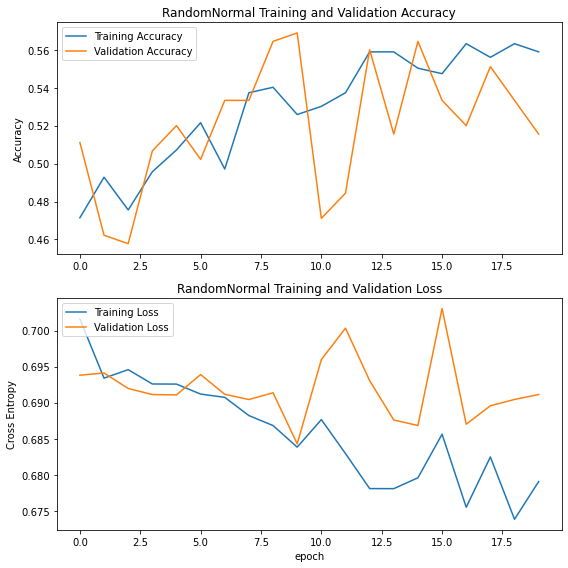

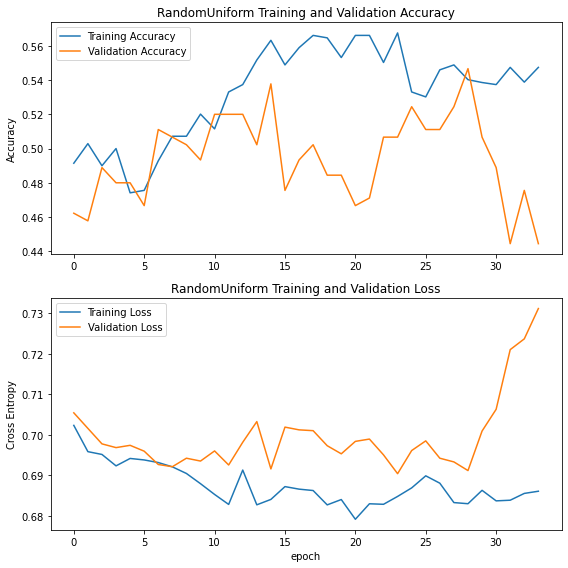

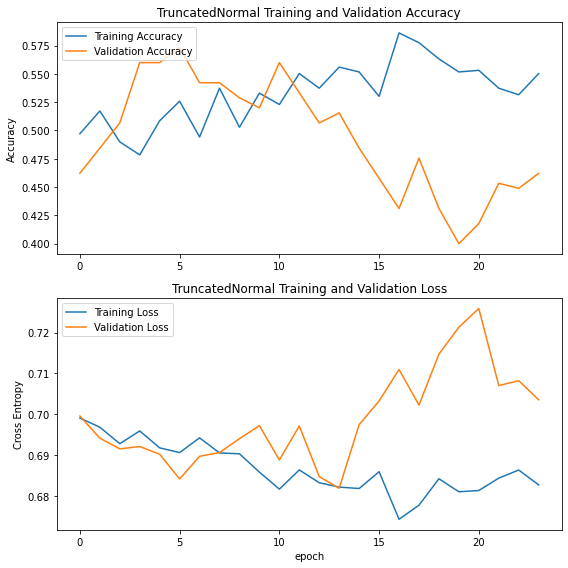

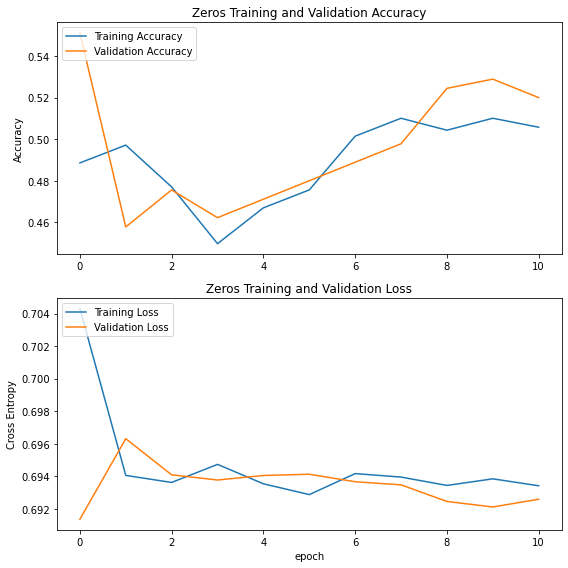

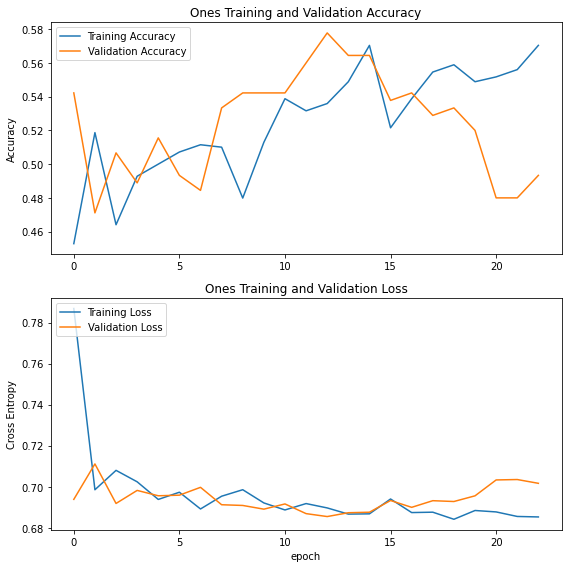

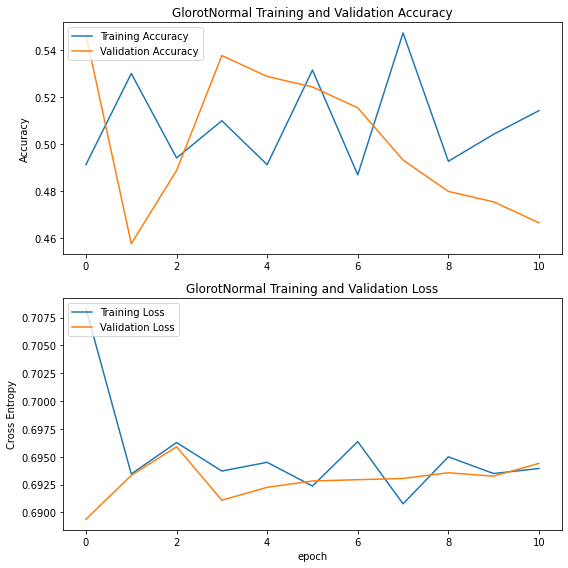

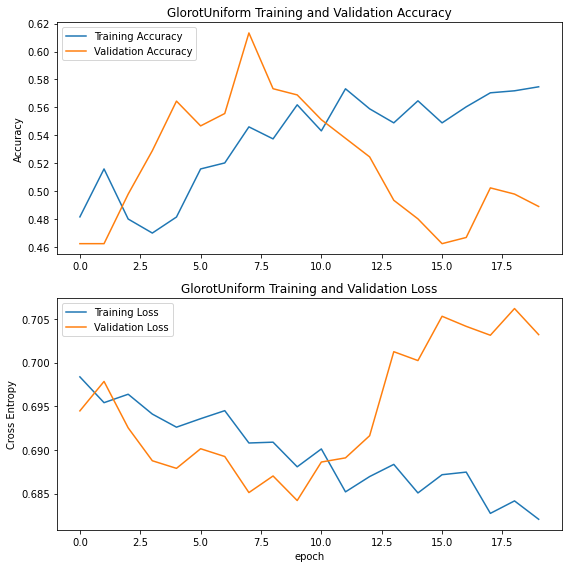

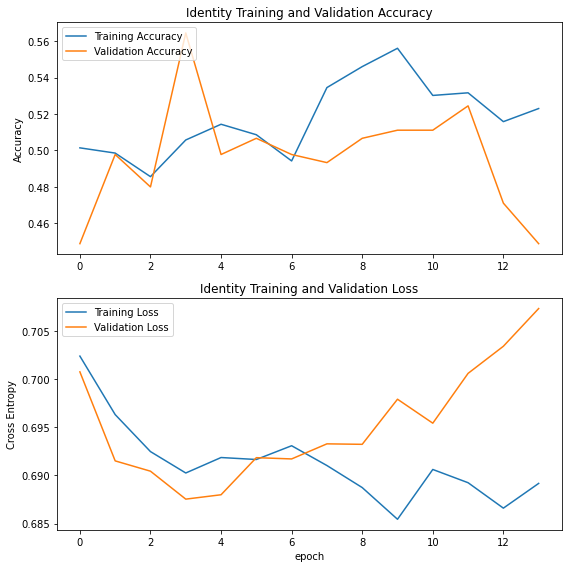

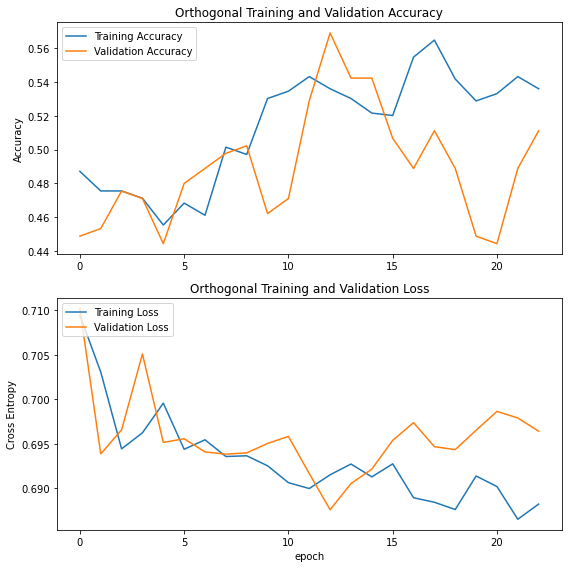

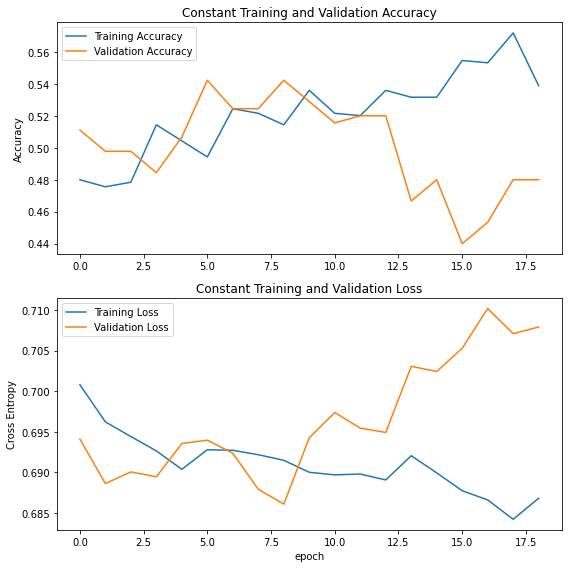

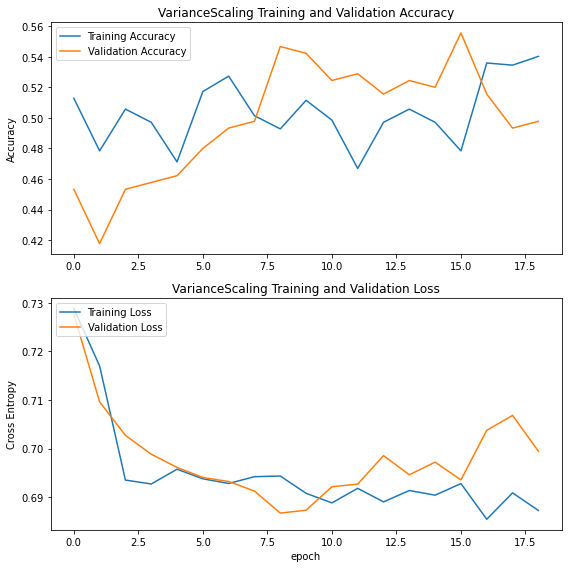

In [27]:
for hist_name in histories.keys():
    display_results(hist_name, histories[hist_name])

## Save point

In [28]:
for name, model in models_ensemble:
    model.save('./models/model_' + name, overwrite=True)

INFO:tensorflow:Assets written to: ./models/model_RandomNormal\assets
INFO:tensorflow:Assets written to: ./models/model_RandomUniform\assets
INFO:tensorflow:Assets written to: ./models/model_TruncatedNormal\assets
INFO:tensorflow:Assets written to: ./models/model_Zeros\assets
INFO:tensorflow:Assets written to: ./models/model_Ones\assets
INFO:tensorflow:Assets written to: ./models/model_GlorotNormal\assets
INFO:tensorflow:Assets written to: ./models/model_GlorotUniform\assets
INFO:tensorflow:Assets written to: ./models/model_Identity\assets
INFO:tensorflow:Assets written to: ./models/model_Orthogonal\assets
INFO:tensorflow:Assets written to: ./models/model_Constant\assets
INFO:tensorflow:Assets written to: ./models/model_VarianceScaling\assets


## Reload models

In [29]:
models_ensemble = list()

RandomNormal = tf.keras.models.load_model('./models/model_RandomNormal')
models_ensemble.append(('RandomNormal', RandomNormal))
RandomUniform = tf.keras.models.load_model('./models/model_RandomUniform')
models_ensemble.append(('RandomUniform', RandomUniform))
TruncatedNormal = tf.keras.models.load_model('./models/model_TruncatedNormal')
models_ensemble.append(('TruncatedNormal', TruncatedNormal))
Zeros = tf.keras.models.load_model('./models/model_Zeros')
models_ensemble.append(('Zeros', Zeros))
Ones = tf.keras.models.load_model('./models/model_Ones')
models_ensemble.append(('Ones', Ones))
GlorotNormal = tf.keras.models.load_model('./models/model_GlorotNormal')
models_ensemble.append(('GlorotNormal', GlorotNormal))
GlorotUniform = tf.keras.models.load_model('./models/model_GlorotUniform')
models_ensemble.append(('GlorotUniform', GlorotUniform))
Identity = tf.keras.models.load_model('./models/model_Identity')
models_ensemble.append(('Identity', Identity))
Orthogonal = tf.keras.models.load_model('./models/model_Orthogonal')
models_ensemble.append(('Orthogonal', Orthogonal))
Constant = tf.keras.models.load_model('./models/model_Constant')
models_ensemble.append(('Constant', Constant))
VarianceScaling = tf.keras.models.load_model('./models/model_VarianceScaling')
models_ensemble.append(('VarianceScaling', VarianceScaling))

## Evaluation

### Convertion data

In [30]:
dataset_val = convert(X_val, y_val)
# convert into input/output
X_val, y_val = split_sequences(dataset_val, n_steps)

### Performance of each sub-model

In [20]:
def model_perf(X, y):
    # Get prediction for each model for validation dataset
    predictions = []

    for name, model in models_ensemble:
        # predict
        prediction = model.predict(X, verbose=0)
        pred = (prediction > 0.5).astype(int)
        predictions.append(pred)

    # Display performance
    perfs = {}
    for j in range(len(predictions)):
        perfs[models_ensemble[j][0]] = accuracy_score(y, predictions[j])

    # Display graph
    x = perfs.keys()
    p = perfs.values()

    x_line = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    y_line = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

    x_pos = [i for i, _ in enumerate(x)]

    plt.bar(x_pos, p, color='steelblue')
    plt.plot(x_line, y_line, linestyle='dashed', color='red')
    plt.xlabel('Modèles')
    plt.ylabel('Accuracy')
    plt.title('Performance par modèle')
    plt.ylim([0.45, 0.65])
    plt.xticks(x_pos, x, rotation=90)
    plt.show()

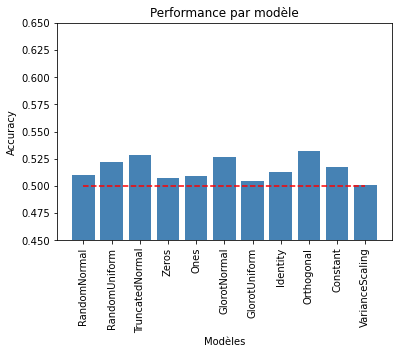

In [32]:
model_perf(X_val, y_val)

## Bayesian Optimization

### Test

In [72]:
# Build models ensemble
models_ensemble.clear()

for name, initializer in k_initializers:
    hp = kt.HyperParameters
    
    def build_model(hp):
        # define model
        model = Sequential()
        model.add(LSTM(hp.Int('nodes_hidden1', 3, 12, step=1),
                       input_shape=(n_steps, n_features),
                       kernel_initializer=initializer,
                       dropout=0,
                       recurrent_dropout=0,
                       return_sequences=True))

        #dropout=hp.Float('dropout', 0, 0.2, step=0.01),
        #recurrent_dropout=hp.Float('rec_dropout', 0, 0.2, step=0.01)

        model.add(LSTM(hp.Int('nodes_hidden2', 3, 12, step=1)))
        model.add(Dense(1, activation='sigmoid'))

        # compile model
        model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, step=0.0001)),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        return model
    
    tuner = kt.BayesianOptimization(hypermodel=build_model,
                                objective='val_loss',
                                max_trials=10,
                                directory='optimization',
                                project_name=name)
    
    tuner.search(iterator(data, 'train', n_steps, 25),
             validation_data=iterator(data, 'valid', n_steps, 25),
             epochs=100,
             steps_per_epoch=28,
             validation_steps=9,
             callbacks=[get_early_stopping(40)])
    
    best_model = tuner.get_best_models(1)[0]
    
    # add model to ensemble
    models_ensemble.append((name, best_model))

Trial 10 Complete [00h 00m 21s]
val_loss: 0.6882887482643127

Best val_loss So Far: 0.6812841296195984
Total elapsed time: 00h 04m 45s
INFO:tensorflow:Oracle triggered exit


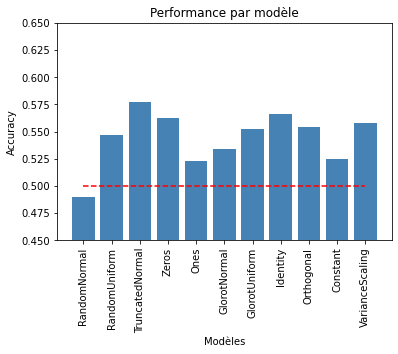

In [73]:
model_perf(X_val, y_val)

### Save point

In [80]:
for name, model in models_ensemble:
    model.save('./models/model_opt_' + name, overwrite=True)

INFO:tensorflow:Assets written to: ./models/model_opt_RandomNormal\assets


INFO:tensorflow:Assets written to: ./models/model_opt_RandomNormal\assets


INFO:tensorflow:Assets written to: ./models/model_opt_RandomUniform\assets


INFO:tensorflow:Assets written to: ./models/model_opt_RandomUniform\assets


INFO:tensorflow:Assets written to: ./models/model_opt_TruncatedNormal\assets


INFO:tensorflow:Assets written to: ./models/model_opt_TruncatedNormal\assets


INFO:tensorflow:Assets written to: ./models/model_opt_Zeros\assets


INFO:tensorflow:Assets written to: ./models/model_opt_Zeros\assets


INFO:tensorflow:Assets written to: ./models/model_opt_Ones\assets


INFO:tensorflow:Assets written to: ./models/model_opt_Ones\assets


INFO:tensorflow:Assets written to: ./models/model_opt_GlorotNormal\assets


INFO:tensorflow:Assets written to: ./models/model_opt_GlorotNormal\assets


INFO:tensorflow:Assets written to: ./models/model_opt_GlorotUniform\assets


INFO:tensorflow:Assets written to: ./models/model_opt_GlorotUniform\assets


INFO:tensorflow:Assets written to: ./models/model_opt_Identity\assets


INFO:tensorflow:Assets written to: ./models/model_opt_Identity\assets


INFO:tensorflow:Assets written to: ./models/model_opt_Orthogonal\assets


INFO:tensorflow:Assets written to: ./models/model_opt_Orthogonal\assets


INFO:tensorflow:Assets written to: ./models/model_opt_Constant\assets


INFO:tensorflow:Assets written to: ./models/model_opt_Constant\assets


INFO:tensorflow:Assets written to: ./models/model_opt_VarianceScaling\assets


INFO:tensorflow:Assets written to: ./models/model_opt_VarianceScaling\assets


## Finalisation

### Get best models

In [21]:
models_ensemble = list()

RandomNormal = tf.keras.models.load_model('./models/model_RandomNormal')
models_ensemble.append(('RandomNormal', RandomNormal))
RandomUniform = tf.keras.models.load_model('./models/model_opt_RandomUniform')
models_ensemble.append(('RandomUniform', RandomUniform))
TruncatedNormal = tf.keras.models.load_model('./models/model_opt_TruncatedNormal')
models_ensemble.append(('TruncatedNormal', TruncatedNormal))
Zeros = tf.keras.models.load_model('./models/model_opt_Zeros')
models_ensemble.append(('Zeros', Zeros))
Ones = tf.keras.models.load_model('./models/model_opt_Ones')
models_ensemble.append(('Ones', Ones))
GlorotNormal = tf.keras.models.load_model('./models/model_opt_GlorotNormal')
models_ensemble.append(('GlorotNormal', GlorotNormal))
GlorotUniform = tf.keras.models.load_model('./models/model_opt_GlorotUniform')
models_ensemble.append(('GlorotUniform', GlorotUniform))
Identity = tf.keras.models.load_model('./models/model_opt_Identity')
models_ensemble.append(('Identity', Identity))
Orthogonal = tf.keras.models.load_model('./models/model_opt_Orthogonal')
models_ensemble.append(('Orthogonal', Orthogonal))
Constant = tf.keras.models.load_model('./models/model_opt_Constant')
models_ensemble.append(('Constant', Constant))
VarianceScaling = tf.keras.models.load_model('./models/model_opt_VarianceScaling')
models_ensemble.append(('VarianceScaling', VarianceScaling))

### Conversion data

In [21]:
dataset_test = convert(X_test, y_test)
# convert into input/output
X_test, y_test = split_sequences(dataset_test, n_steps)

In [22]:
X_test.shape

(241, 30, 22)

In [23]:
y_test.shape

(241,)

### Check performances

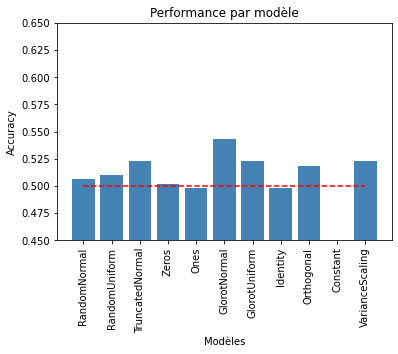

In [23]:
model_perf(X_test, y_test)

### Prediction without ponderation

In [24]:
predictions_nop = []

for name, model in models_ensemble:
    # predict
    prediction = model.predict(X_test, verbose=0)
    test_pred_nop = (prediction > 0.5).astype(int)
    predictions_nop.append(test_pred_nop)

In [25]:
final_pred_nop = []

for i in range(len(predictions_nop[0])):
    count = 0
    for j in range (len(predictions_nop)):
        count += predictions_nop[j][i][0]
    
    if count >= 6:
        final_pred_nop.append(1)
    else:
        final_pred_nop.append(0)   

In [26]:
print('confusion matrix')
print(confusion_matrix(y_test, final_pred_nop))
print('')
print("accuracy:", accuracy_score(y_test, final_pred_nop))

confusion matrix
[[69 59]
 [65 48]]

accuracy: 0.4854771784232365


### Prediction with ponderation

In [28]:
predictions_p = []

for name, model in models_ensemble:
    # predict
    prediction = model.predict(X_test, verbose=0)
    predictions_p.append(prediction)

In [29]:
final_pred_p = []

for i in range(len(predictions_p[0])):
    count = 0
    for j in range (len(predictions_p)):
        if j in [0, 1]:
            count += predictions_p[j][i][0] * 2
        elif j in [2, 5, 6, 8, 10]:
            count += predictions_p[j][i][0] * 3
        else:
            count += predictions_p[j][i][0]
    
    ponderate = count / 23
    
    if ponderate >= 0.5:
        final_pred_p.append(1)
    else:
        final_pred_p.append(0)    

In [30]:
print('confusion matrix')
print(confusion_matrix(y_test, final_pred_p))
print('')
print("accuracy:", accuracy_score(y_test, final_pred_p))

confusion matrix
[[76 52]
 [59 54]]

accuracy: 0.5394190871369294
